In [ ]:
import pandas as pd

df = pd.read_csv("/content/TASK-ML-INTERN.csv")
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None
                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  ...         439  \
count  500.000000  

In [ ]:
df.shape

(500, 450)

In [ ]:
print(df.isnull().sum().sum())


0


no null values found

hsi_id column is not suitable/nesseary for the model trainnig

In [ ]:
df.drop(columns=['hsi_id'], inplace=True)

used IQR method with capping so that the number of rows remain intact

In [ ]:
import numpy as np

def cap_outliers_iqr(df, columns):
    """
    Cap outliers in the given dataframe columns using the IQR method.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR  # Lower threshold
        upper_bound = Q3 + 1.5 * IQR  # Upper threshold

        # Cap values at lower and upper bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Apply capping to spectral reflectance features (exclude 'hsi_id' and 'vomitoxin_ppb')
spectral_cols = df.columns.difference(['vomitoxin_ppb'])  # Select only feature columns
df = cap_outliers_iqr(df, spectral_cols)





In [ ]:
df.skew()

,0
0,-0.329651
1,-0.265949
2,-0.247102
3,-0.168448
4,-0.160250
...,...
444,-0.002611
445,-0.007606
446,-0.049796
447,-0.056658


Robust Scaler as data is slightly skewed

In [ ]:
from sklearn.preprocessing import RobustScaler

X = df.drop(columns=['vomitoxin_ppb'])
y = df['vomitoxin_ppb']

# RobustScaler for handling skewed data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Visualizations

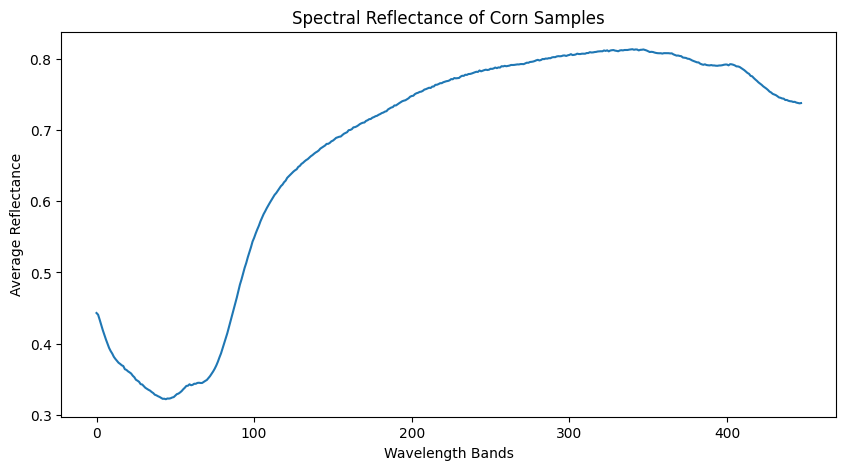

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(448), X.mean(axis=0))  # Average reflectance per band
plt.xlabel("Wavelength Bands")
plt.ylabel("Average Reflectance")
plt.title("Spectral Reflectance of Corn Samples")
plt.show()


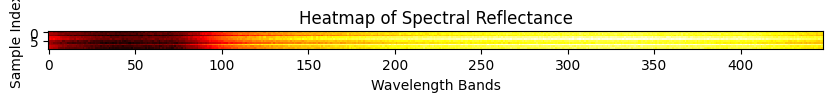

In [ ]:
# HEATMAP (example)
plt.figure(figsize=(10, 8))
plt.imshow(X.head(10), cmap='hot', interpolation='nearest')
plt.title('Heatmap of Spectral Reflectance')
plt.xlabel('Wavelength Bands')
plt.ylabel('Sample Index')
plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

# keeping 99.9% colummns for better results
pca = PCA(n_components=0.999)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X.shape[1]}, Reduced features: {X_pca.shape[1]}")


Original features: 448, Reduced features: 67


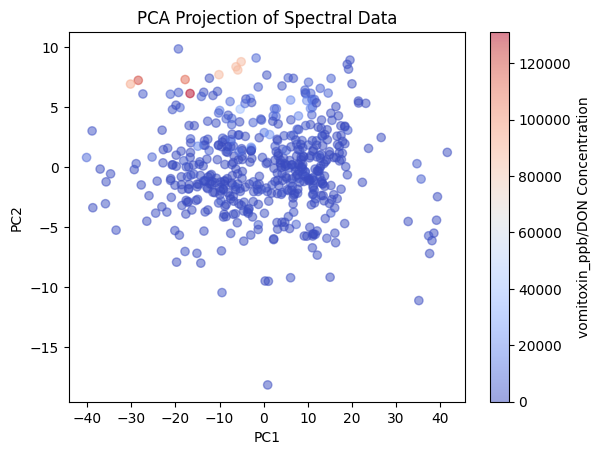

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Spectral Data")
plt.colorbar(label="vomitoxin_ppb/DON Concentration")
plt.show()

# Model trainning

using MLP regressor with random searchCV for hyperparameter tunning

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the MLP model
mlp = MLPRegressor(max_iter=1000, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],  # Different architectures
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam'],  # Optimizer
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'learning_rate_init': [0.001, 0.01]  # Learning rates
}

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=3, scoring='r2', verbose=2, n_jobs=-1)
random_search.fit(X_pca, y)

# Best parameters and model
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'activation': 'tanh'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
best_model.set_params(max_iter=3000)  # Increase iterations
best_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(128, 64),
             learning_rate_init=0.01, max_iter=3000, random_state=42)

In [ ]:
best_model.set_params(learning_rate_init=0.0001)  # Reduce step size


MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(128, 64),
             learning_rate_init=0.0001, max_iter=3000, random_state=42)

In [ ]:
best_model.set_params(solver='adam', beta_1=0.9, beta_2=0.999)


MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(128, 64),
             learning_rate_init=0.0001, max_iter=3000, random_state=42)

Model Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Train model using scaled target
best_model.fit(X_train, y_train_scaled)

# Make predictions and inverse transform
y_pred_scaled = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()


In [ ]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MAE: 5723.3044, RMSE: 10162.9985, R²: 0.6305
